# Import

In [ ]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import time
import os
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Connect to data

In [ ]:
#Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load PoG labels csv

In [ ]:
#Add labels csv

#df_labels = pd.read_csv('/content/drive/MyDrive/gaze_labels.csv')
df_labels = pd.read_csv('/content/drive/MyDrive/gaze_labels.csv', dtype={'subject_id': str})#
print(f"Loaded {len(df_labels)} labeled frames")
df_labels.head()

Loaded 849131 labeled frames


,subject_id,frame_idx,pog_x,pog_y,label
0,00002,0,1.064000,-6.005500,Down
1,00002,1,1.064000,-6.005500,Down
2,00002,2,1.064000,-6.005500,Down
3,00002,3,1.064000,-6.005500,Down
4,00002,4,3.251485,-1.993073,Straight


# Are we on GPU?

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Extract Images from tar files

In [ ]:
tar_files = sorted([f'/content/drive/MyDrive/gaze_wds/{f}'
                    for f in os.listdir('/content/drive/MyDrive/gaze_wds/')
                    if f.endswith('.tar')])

In [ ]:
import tarfile, os

extract_dir = '/content/gaze_images'
os.makedirs(extract_dir, exist_ok=True)

for i, tp in enumerate(tar_files):
    with tarfile.open(tp, 'r') as tar:
        tar.extractall(extract_dir)
    #print(f"Extracted {i+1}/{len(tar_files)}")
    print(f"\rExtracted {i+1}/{len(tar_files)}", end='')

print("Done!")

/tmp/ipython-input-1079247385.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_dir)


Extracted 1/284
Extracted 2/284
Extracted 3/284
Extracted 4/284
Extracted 5/284
Extracted 6/284
Extracted 7/284
Extracted 8/284
Extracted 9/284
Extracted 10/284
Extracted 11/284
Extracted 12/284
Extracted 13/284
Extracted 14/284
Extracted 15/284
Extracted 16/284
Extracted 17/284
Extracted 18/284
Extracted 19/284
Extracted 20/284
Extracted 21/284
Extracted 22/284
Extracted 23/284
Extracted 24/284
Extracted 25/284
Extracted 26/284
Extracted 27/284
Extracted 28/284
Extracted 29/284
Extracted 30/284
Extracted 31/284
Extracted 32/284
Extracted 33/284
Extracted 34/284
Extracted 35/284
Extracted 36/284
Extracted 37/284
Extracted 38/284
Extracted 39/284
Extracted 40/284
Extracted 41/284
Extracted 42/284
Extracted 43/284
Extracted 44/284
Extracted 45/284
Extracted 46/284
Extracted 47/284
Extracted 48/284
Extracted 49/284
Extracted 50/284
Extracted 51/284
Extracted 52/284
Extracted 53/284
Extracted 54/284
Extracted 55/284
Extracted 56/284
Extracted 57/284
Extracted 58/284
Extracted 59/284
Extrac

# Create Dataset  Class

Note to self -- Updating this  Dataset class to read from the extracted /content/gaze_images/ folder instead of opening tar files.   Right now, every time the training loop needs one sample, __getitem__ does this:

1. Opens a tar file (which is a big archive containing thousands of files)
2. Searches through the tar to find the 3 images it needs
3. Reads those 3 images
4. Closes the tar file

With 849K samples, that's 849K times per epoch. Opening and scanning a tar file is slow — it's like unzipping a zip file just to read one photo, then zipping it back up, over and over.

In [ ]:
#revised see notes above
class GazeCaptureDataset(Dataset):
    def __init__(self, df_labels, img_dir, eye_transform=None, face_transform=None, subject_filter=None):
        self.img_dir = img_dir
        self.eye_transform = eye_transform
        self.face_transform = face_transform

        if subject_filter is not None:
            self.df = df_labels[df_labels['subject_id'].isin(subject_filter)].reset_index(drop=True)
        else:
            self.df = df_labels.reset_index(drop=True)

        print(f"Dataset loaded: {len(self.df)} samples")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        base = f"{row['subject_id']}_{row['frame_idx']:06d}"

        face = np.array(Image.open(f'{self.img_dir}/{base}.face.jpg'))
        left_eye = np.array(Image.open(f'{self.img_dir}/{base}.left.jpg'))
        right_eye = np.array(Image.open(f'{self.img_dir}/{base}.right.jpg'))

        if self.eye_transform:
            left_eye = self.eye_transform(left_eye)
            right_eye = self.eye_transform(right_eye)
        if self.face_transform:
            face = self.face_transform(face)

        label_map = {'Straight': 0, 'Up': 1, 'Down': 2, 'Left': 3, 'Right': 4}
        label_idx = label_map[row['label']]

        return {
            'left_eye': left_eye,
            'right_eye': right_eye,
            'face': face,
            'label': torch.tensor(label_idx, dtype=torch.long)
        }

In [ ]:
# #DELETE - old version that unzips and zips each file

# class GazeCaptureDataset(Dataset):
#     def __init__(self, tar_files, df_labels, eye_transform=None, face_transform=None, subject_filter=None):
#         self.tar_files = tar_files
#         self.eye_transform = eye_transform
#         self.face_transform = face_transform

#         # Filter by subjects if provided
#         if subject_filter is not None:
#             self.df = df_labels[df_labels['subject_id'].isin(subject_filter)].reset_index(drop=True)
#         else:
#             self.df = df_labels.reset_index(drop=True)

#         # Build index mapping frame to its tar file
#         print("Building index...")
#         self.frame_index = {}
#         for tp in tar_files:
#             tar = tarfile.open(tp, 'r')
#             names = [m.name for m in tar.getmembers()]
#             for name in names:
#                 if name.endswith('.face.jpg'):
#                     key = name.replace('.face.jpg', '')
#                     self.frame_index[key] = tp
#             tar.close()

#         print(f"Dataset loaded: {len(self.df)} samples")

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         subject_id = row['subject_id']
#         frame_idx = row['frame_idx']

#         # Build filename base
#         base = f"{subject_id}_{frame_idx:06d}"
#         tp = self.frame_index[base]

#         # Load images from tar
#         tar = tarfile.open(tp, 'r')
#         face = np.array(Image.open(tar.extractfile(f'{base}.face.jpg')))
#         left_eye = np.array(Image.open(tar.extractfile(f'{base}.left.jpg')))
#         right_eye = np.array(Image.open(tar.extractfile(f'{base}.right.jpg')))
#         tar.close()

#         # Apply transforms
#         if self.eye_transform:
#             left_eye = self.eye_transform(left_eye)
#             right_eye = self.eye_transform(right_eye)
#         if self.face_transform:
#             face = self.face_transform(face)

#         # Get label
#         label_map = {'Straight': 0, 'Up': 1, 'Down': 2, 'Left': 3, 'Right': 4}
#         label_idx = label_map[row['label']]

#         return {
#             'left_eye': left_eye,
#             'right_eye': right_eye,
#             'face': face,
#             'label': torch.tensor(label_idx, dtype=torch.long)
#         }

In [ ]:
#Revised -Sanity check with one sample to make sure images and labels load
test_dataset = GazeCaptureDataset(
    df_labels=df_labels,
    img_dir='/content/gaze_images'
)

# Try loading one sample
sample = test_dataset[0]
print("Sample keys:", sample.keys())
print("Face shape:", sample['face'].shape)
print("Left eye shape:", sample['left_eye'].shape)
print("Right eye shape:", sample['right_eye'].shape)
print("Label:", sample['label'])

Dataset loaded: 849131 samples
Sample keys: dict_keys(['left_eye', 'right_eye', 'face', 'label'])
Face shape: (112, 112, 3)
Left eye shape: (36, 60, 3)
Right eye shape: (36, 60, 3)
Label: tensor(2)


# Define Transformation

In [ ]:
#Define transformations of images
eye_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((64, 64)),
    transforms.Resize((48, 48)),  #DownSampled from 64x64 to improve training time
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

face_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize((112, 112)),  #DownSampled from 224 x 224 to 112 during EDA to reduce inference time
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create Dataset

In [ ]:
#Convert raw data to dataset
dataset = GazeCaptureDataset(
    df_labels=df_labels,
    img_dir='/content/gaze_images',
    eye_transform=eye_transform,
    face_transform=face_transform
)

Dataset loaded: 849131 samples


In [ ]:
# #DELETE -- old version before Opus

# #Convert raw data (tar files and csv) to dataset
# dataset = GazeCaptureDataset(
#     tar_files=tar_files,
#     df_labels=df_labels,
#     eye_transform=eye_transform,
#     face_transform=face_transform
# )

Building index...
Dataset loaded: 849131 samples


#Pipeline Spotcheck

In [ ]:
#Verify images, subject ID, frame index and label load correctly from tar files and csv

print("\nTesting dataset...")
label_names = {0: 'Straight', 1: 'Up', 2: 'Down', 3: 'Left', 4: 'Right'}

for i in range(5):
    row = dataset.df.iloc[i]
    sample = dataset[i]
    print(f"Frame {i}:")
    print(f"  Subject ID: {row['subject_id']}")
    print(f"  Frame Index: {row['frame_idx']}")
    print(f"  Gaze Direction: {label_names[sample['label'].item()]}")
    print(f"  Face shape: {sample['face'].shape}")
    print(f"  Left eye shape: {sample['left_eye'].shape}")
    print(f"  Right eye shape: {sample['right_eye'].shape}")
    print()


Testing dataset...
Frame 0:
  Subject ID: 00002
  Frame Index: 0
  Gaze Direction: Down
  Face shape: torch.Size([3, 112, 112])
  Left eye shape: torch.Size([3, 48, 48])
  Right eye shape: torch.Size([3, 48, 48])

Frame 1:
  Subject ID: 00002
  Frame Index: 1
  Gaze Direction: Down
  Face shape: torch.Size([3, 112, 112])
  Left eye shape: torch.Size([3, 48, 48])
  Right eye shape: torch.Size([3, 48, 48])

Frame 2:
  Subject ID: 00002
  Frame Index: 2
  Gaze Direction: Down
  Face shape: torch.Size([3, 112, 112])
  Left eye shape: torch.Size([3, 48, 48])
  Right eye shape: torch.Size([3, 48, 48])

Frame 3:
  Subject ID: 00002
  Frame Index: 3
  Gaze Direction: Down
  Face shape: torch.Size([3, 112, 112])
  Left eye shape: torch.Size([3, 48, 48])
  Right eye shape: torch.Size([3, 48, 48])

Frame 4:
  Subject ID: 00002
  Frame Index: 4
  Gaze Direction: Straight
  Face shape: torch.Size([3, 112, 112])
  Left eye shape: torch.Size([3, 48, 48])
  Right eye shape: torch.Size([3, 48, 48])



# Baseline: Dominant Class Prediction of PoG labels

In [ ]:
#Dominant class prediction
from collections import Counter

label_counts = Counter(df_labels['label'])
most_common_label, most_common_count = label_counts.most_common(1)[0]
dominant_class_accuracy = (most_common_count / len(df_labels)) * 100

print("=" * 60)
print("BASELINE: Dominant Class Prediction")
print("=" * 60)
print(f"Most common class: {most_common_label}")
print(f"Baseline accuracy (always predict '{most_common_label}'): {dominant_class_accuracy:.2f}%")
print(f"This is our 'dumb' baseline to beat.")

BASELINE: Dominant Class Prediction
Most common class: Straight
Baseline accuracy (always predict 'Straight'): 29.05%
This is our 'dumb' baseline to beat.


# Define Baseline (CNN) Model

In [ ]:
#Define multi-stream CNN that processes images (face & eye) for gaze direction classification


class GazeNet(nn.Module):
    """
    Multi-stream CNN for gaze direction classification.

    Takes left eye, right eye, and face images as input, processes
    them through separate CNNs, combines the learned representations,
    and classifies gaze into 5 directions (Straight, Up, Down, Left, Right).

    Args:
        num_classes (int): Number of gaze direction classes. Default: 5
    """
    def __init__(self, num_classes=5):
        super(GazeNet, self).__init__()

        # Eye CNN - processes left and right eye (shared weights)
        self.eye_cnn = nn.Sequential(
            # Input: (3, 48, 48)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (32, 24, 24)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (64, 12, 12)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (128, 6, 6)
        )

        # Face CNN
        self.face_cnn = nn.Sequential(
            # Input: (3, 112, 112)
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (32, 28, 28)

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (64, 14, 14)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (128, 7, 7)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (256, 3, 3)
        )

        # Fully connected layers
        # Eye features: 128 * 6 * 6 = 4608 per eye
        # Face features: 256 * 3 * 3 = 2304
        # Total: 4608 + 4608 + 2304 = 11520

        self.fc = nn.Sequential(
            nn.Linear(128*6*6*2 + 256*3*3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, left_eye, right_eye, face):
        # Process eyes (same CNN for both)
        left_features = self.eye_cnn(left_eye)
        right_features = self.eye_cnn(right_eye)

        # Process face
        face_features = self.face_cnn(face)

        # Flatten all features
        left_flat = left_features.view(left_features.size(0), -1)
        right_flat = right_features.view(right_features.size(0), -1)
        face_flat = face_features.view(face_features.size(0), -1)

        # Concatenate all features
        combined = torch.cat([left_flat, right_flat, face_flat], dim=1)

        # Final classification
        output = self.fc(combined)

        return output

In [ ]:
# old version - DELETE
#Define the model class

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class GazeNet(nn.Module):
#     """
#     Multi-stream CNN for gaze direction classification.

#     Takes left eye, right eye, and face images as input, processes
#     them through separate CNNs, combines the learned representations,
#     and classifies gaze into 5 directions (Straight, Up, Down, Left, Right).

#     Args:
#         num_classes (int): Number of gaze direction classes. Default: 5
#     """
#     def __init__(self, num_classes=5):
#         super(GazeNet, self).__init__()









#         #Eye CNN - processes left and right eye (shared weights)
#         self.eye_cnn = nn.Sequential(
#             # Input: (3, 64, 64)
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # -> (32, 32, 32)

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # -> (64, 16, 16)

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # -> (128, 8, 8)
#         )

#         #Face CNN
#         self.face_cnn = nn.Sequential(
#             # Input: (3, 224, 224)
#             nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # -> (32, 56, 56)

#             nn.Conv2d(32, 64, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # -> (64, 28, 28)

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # -> (128, 14, 14)

#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # -> (256, 7, 7)
#         )

#         # Fully connected layers
#         # Eye features: 128 * 8 * 8 = 8192 per eye
#         # Face features: 256 * 7 * 7 = 12544
#         # Total: 8192 + 8192 + 12544 = 28928

#         self.fc = nn.Sequential(
#             #nn.Linear(128*8*8*2 + 256*7*7, 512),
#             nn.Linear(128*6*6*2 + 256*3*3, 512),  #for 48x48 eyes, 112x112 face
#             nn.ReLU(),
#             nn.Dropout(0.5),

#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),

#             nn.Linear(256, num_classes)
#         )

#     def forward(self, left_eye, right_eye, face):
#         # Process eyes (same CNN for both)
#         left_features = self.eye_cnn(left_eye)
#         right_features = self.eye_cnn(right_eye)

#         # Process face
#         face_features = self.face_cnn(face)

#         # Flatten all features
#         left_flat = left_features.view(left_features.size(0), -1)
#         right_flat = right_features.view(right_features.size(0), -1)
#         face_flat = face_features.view(face_features.size(0), -1)

#         # Concatenate all features
#         combined = torch.cat([left_flat, right_flat, face_flat], dim=1)

#         # Final classification
#         output = self.fc(combined)

#         return output


# Split the data

In [ ]:
# Split by subject so all frames for a subject are in the same split
import numpy as np

# Get all unique subjects from df_labels
all_subjects = sorted(df_labels['subject_id'].unique())
print(f"Total unique subjects: {len(all_subjects)}")

# Shuffle subjects reproducibly
np.random.seed(42)
shuffled_subjects = np.random.permutation(all_subjects)

# Split: 70% train, 15% val, 15% test
n_subjects = len(shuffled_subjects)
train_end = int(0.70 * n_subjects)
val_end = int(0.85 * n_subjects)

train_subjects = set(shuffled_subjects[:train_end])
val_subjects = set(shuffled_subjects[train_end:val_end])
test_subjects = set(shuffled_subjects[val_end:])

print(f"\nTrain subjects: {len(train_subjects)}")
print(f"Val subjects: {len(val_subjects)}")
print(f"Test subjects: {len(test_subjects)}")

Total unique subjects: 640

Train subjects: 448
Val subjects: 96
Test subjects: 96


# Create Datasets from splits

In [ ]:
#Create train/val/test datasets with subject filtering
train_dataset = GazeCaptureDataset(
    df_labels=df_labels,
    img_dir='/content/gaze_images',
    eye_transform=eye_transform,
    face_transform=face_transform,
    subject_filter=train_subjects
)

val_dataset = GazeCaptureDataset(
    df_labels=df_labels,
    img_dir='/content/gaze_images',
    eye_transform=eye_transform,
    face_transform=face_transform,
    subject_filter=val_subjects
)

test_dataset = GazeCaptureDataset(
    df_labels=df_labels,
    img_dir='/content/gaze_images',
    eye_transform=eye_transform,
    face_transform=face_transform,
    subject_filter=test_subjects
)

print(f"Train frames: {len(train_dataset)}")
print(f"Val frames: {len(val_dataset)}")
print(f"Test frames: {len(test_dataset)}")

Dataset loaded: 600486 samples
Dataset loaded: 115603 samples
Dataset loaded: 133042 samples
Train frames: 600486
Val frames: 115603
Test frames: 133042


In [ ]:
#old version --uses tar_files

# #Create train/val/test datasets with subject filtering

# train_dataset = GazeCaptureDataset(
#     tar_files=tar_files,
#     df_labels=df_labels,
#     eye_transform=eye_transform,
#     face_transform=face_transform,
#     subject_filter=train_subjects
# )

# val_dataset = GazeCaptureDataset(
#     tar_files=tar_files,
#     df_labels=df_labels,
#     eye_transform=eye_transform,
#     face_transform=face_transform,
#     subject_filter=val_subjects
# )

# test_dataset = GazeCaptureDataset(
#     tar_files=tar_files,
#     df_labels=df_labels,
#     eye_transform=eye_transform,
#     face_transform=face_transform,
#     subject_filter=test_subjects
# )

# print(f"Train frames: {len(train_dataset)}")
# print(f"Val frames: {len(val_dataset)}")
# print(f"Test frames: {len(test_dataset)}")

Building index...
Dataset loaded: 600486 samples
Building index...
Dataset loaded: 115603 samples
Building index...
Dataset loaded: 133042 samples
Train frames: 600486
Val frames: 115603
Test frames: 133042


# Create DataLoaders

In [ ]:
#Create dataloaders for each split
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    #num_workers=0,
    #num_workers=4, #safe now that we are not reading from tar files
    num_workers=2, #recommended by colab
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,  #Don't shuffle validation
    #num_workers=0,
    #num_workers=4, #safe now that we are not reading from tar files
    num_workers=2, #recommended by colab
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,  #Don't shuffle test
    #num_workers=0,
    #num_workers=4, #safe now that we are not reading from tar files
    num_workers=2, #recommended by colab
    pin_memory=True
)

#Show me how many
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 18766
Val batches: 3613
Test batches: 4158


# Initialize Model

In [ ]:
#Model, loss function, optimizer, and learning rate scheduler

model = GazeNet(num_classes=5).to(device)

#Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

print("Model, loss, and optimizer are ready")

Model, loss, and optimizer ready!


# Memory Check

In [ ]:
#Memory check
!df -h /content/

Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   65G  172G  28% /


#Verify Checkpoints folder exists

In [ ]:
!mkdir -p /content/drive/MyDrive/checkpoints

file_count = !ls /content/drive/MyDrive/checkpoints/ | wc -l
if int(file_count[0]) == 0:
    print("Checkpoints directory ready (empty - no models saved yet)")
else:
    print("Checkpoints directory contents:")
    !ls -la /content/drive/MyDrive/checkpoints/

Checkpoints directory ready (empty - no models saved yet)


# Train& Save Model to Google Drive

In [ ]:
#Training configuration
num_epochs = 10
best_val_loss = float('inf')

#Training loop
for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*50}")

    # ============================================
    # TRAINING PHASE
    # ============================================
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, batch in enumerate(train_loader):
        #Move data to device
        left_eye = batch['left_eye'].to(device)
        right_eye = batch['right_eye'].to(device)
        face = batch['face'].to(device)
        labels = batch['label'].to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(left_eye, right_eye, face)
        loss = criterion(outputs, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        #Track metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        #Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    #Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total

    # ============================================
    # VALIDATION PHASE
    # ============================================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            left_eye = batch['left_eye'].to(device)
            right_eye = batch['right_eye'].to(device)
            face = batch['face'].to(device)
            labels = batch['label'].to(device)

            outputs = model(left_eye, right_eye, face)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    #Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    #Update learning rate
    scheduler.step(avg_val_loss)

    #Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    #Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/checkpoints/best_gazenet_model.pth')
        #torch.save(model.state_dict(), 'best_gazenet_model.pth')
        print(f"  ✓ New best model saved!")

print("\n" + "="*50)
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")


Epoch 1/10
  Batch 100/18766 - Loss: 1.0687
  Batch 200/18766 - Loss: 1.2003
  Batch 300/18766 - Loss: 1.1152
  Batch 400/18766 - Loss: 1.1847
  Batch 500/18766 - Loss: 1.1985
  Batch 600/18766 - Loss: 0.7520
  Batch 700/18766 - Loss: 0.9555
  Batch 800/18766 - Loss: 0.6574
  Batch 900/18766 - Loss: 0.7880
  Batch 1000/18766 - Loss: 1.0628
  Batch 1100/18766 - Loss: 0.7391
  Batch 1200/18766 - Loss: 0.7171
  Batch 1300/18766 - Loss: 0.9188
  Batch 1400/18766 - Loss: 0.5965
  Batch 1500/18766 - Loss: 0.6687
  Batch 1600/18766 - Loss: 0.9081
  Batch 1700/18766 - Loss: 0.6982
  Batch 1800/18766 - Loss: 0.6640
  Batch 1900/18766 - Loss: 0.6201
  Batch 2000/18766 - Loss: 0.5786
  Batch 2100/18766 - Loss: 0.7282
  Batch 2200/18766 - Loss: 0.7303
  Batch 2300/18766 - Loss: 0.5407
  Batch 2400/18766 - Loss: 0.9328
  Batch 2500/18766 - Loss: 0.4708
  Batch 2600/18766 - Loss: 0.6292
  Batch 2700/18766 - Loss: 0.4878
  Batch 2800/18766 - Loss: 0.8005
  Batch 2900/18766 - Loss: 0.7344
  Batch 300

# Loss Curves

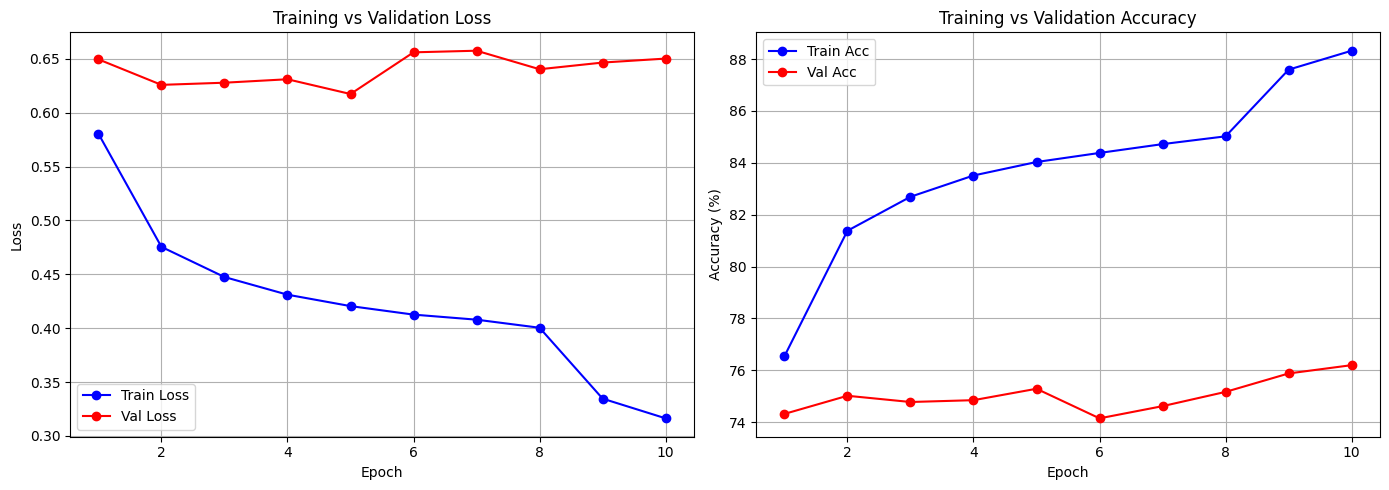

In [ ]:
#Training and Validation Loss/Accuracy Curves
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_losses = [0.5806, 0.4755, 0.4475, 0.4311, 0.4205, 0.4126, 0.4079, 0.4004, 0.3346, 0.3163]
val_losses =   [0.6496, 0.6259, 0.6279, 0.6311, 0.6174, 0.6561, 0.6576, 0.6404, 0.6466, 0.6503]
train_accs =   [76.54, 81.38, 82.69, 83.51, 84.03, 84.38, 84.72, 85.02, 87.59, 88.32]
val_accs =     [74.32, 75.02, 74.78, 74.85, 75.29, 74.15, 74.62, 75.17, 75.88, 76.20]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, train_losses, 'b-o', label='Train Loss')
ax1.plot(epochs, val_losses, 'r-o', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training vs Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, train_accs, 'b-o', label='Train Acc')
ax2.plot(epochs, val_accs, 'r-o', label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training vs Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Loss Summary:  The loss plot shows train loss steadily dropping while val loss stayed flat and even crept up — classic overfitting pattern.

The accuracy plot shows the same thing — train accuracy climbing to 88% while val accuracy plateaued around 74-76%.

The baseline is solid at ~75% validation accuracy, far above the 29% dominant class.

When training loss keeps decreasing but validation loss stays flat or increases, it indicates overfitting. The model is memorizing the training data rather than learning generalizable gaze patterns. This divergence started around epoch 5, which is why the best model was saved at epoch 5. The learning rate scheduler helped briefly by cutting the learning rate after epochs of no improvement, but ultimately the model reached its generalization ceiling around 75% validation accuracy. For a baseline model this is a strong result, more than doubling the 29% dominant class prediction accuracy.

#Evaluation & Confusion Matrix

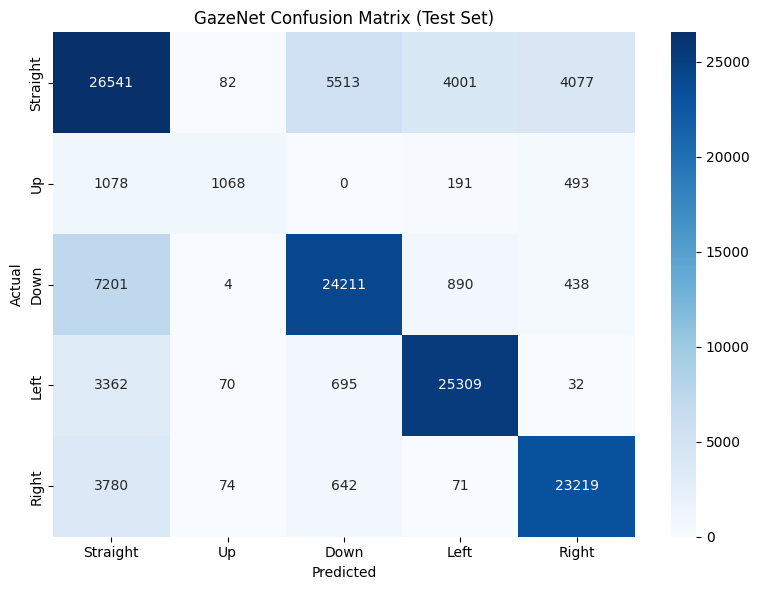

              precision    recall  f1-score   support

    Straight       0.63      0.66      0.65     40214
          Up       0.82      0.38      0.52      2830
        Down       0.78      0.74      0.76     32744
        Left       0.83      0.86      0.84     29468
       Right       0.82      0.84      0.83     27786

    accuracy                           0.75    133042
   macro avg       0.78      0.69      0.72    133042
weighted avg       0.76      0.75      0.75    133042



In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('/content/drive/MyDrive/checkpoints/best_gazenet_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        left_eye = batch['left_eye'].to(device)
        right_eye = batch['right_eye'].to(device)
        face = batch['face'].to(device)
        labels = batch['label'].to(device)

        outputs = model(left_eye, right_eye, face)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

label_names = ['Straight', 'Up', 'Down', 'Left', 'Right']
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GazeNet Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print(classification_report(all_labels, all_preds, target_names=label_names))

Left and Right perform best (f1 scores of 0.84 and 0.83), which makes sense since those have the most distinct eye patterns.

The model struggles most with "Up" — only 38% recall with just 2,830 test samples. It's the smallest class and the model often misclassifies Up as Straight or Right.

"Straight" has decent recall (66%) but low precision (63%) because many samples from other classes get incorrectly predicted as Straight, especially from Down (7,201), Left (3,362), and Right (3,780).

"Down" gets confused with "Straight" a lot (7,201 misclassifications), which makes sense since both involve relatively similar eye positions.


Overall test accuracy looks like about 75%, consistent with your validation results. For a baseline this is solid. The confusion patterns give you good direction for your main model — it could benefit from better handling of the Up class and distinguishing Straight from Down.